**Índice**

- [Librerias](#librerias)
- [Carga de datos](#carga)
- [Información del dataframe de usuario](#info_user)
- [Crosstab TIPOUSUARIO ~ IND_CLIENTE](#crosstab)
- [Creacion del sub-dataset](#subset)
- [Cambio del tipo de datos](#cambiotipodatos)
- [Rellenar valores NaN](#rellenar)
- [Proporcion de Clientes vs No Clientes](#proporcion)
- [Análisis de la dependencia de las variables categóricas](#dependencia_cat)
- [Análisis de la dependencia de las variables continuas](#dependencia_cont)
- [Separar los datos entre Train y Test](#traintest)
- [knn](#knn)
    - [Busqueda de hiperparámetros](#knn_hiper)
    - [Crear el modelo Knn](#knn_crear)
- [Random Forest](#randomforest)
    - [Busqueda de hiperparámetros](#rf_hiper)
    - [Crear el modelo de Random Forest](#rf_crear)
- [XGBoost](#xgb)
    - [Busqueda de hiperparámetros](#xgb_hiper)
    - [Crear el modelo de XGBoost](#xgb_crear)
- [Análisis de resultados](#resultados)
- [Escenario 2. Tipo de usuario = PF](#escenario2)
    - [Resultados escenario 2](#resultados2)
- [Escenario 3. Sin separar por tipo de usuario](#escenario3)
    - [Resultados escenario 3](#resultados3)

## Librerias
<a name='librerias' />

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score,mean_absolute_error,mean_squared_error,recall_score
from IPython.display import Markdown as md
from scipy.stats import chi2_contingency, chi2, stats
from pandas_profiling import ProfileReport
from datetime import datetime
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")


## Carga de datos
<a name='carga' />

In [3]:

file_user = 'C:\\Users\\nserr\\OneDrive\\Documentos\\Master Ciencia de Datos\\TFM\\Dataset\\Usuarios.csv'

data_user = pd.read_csv(file_user,delimiter=';', encoding = 'ansi')

In [4]:
file_consum = 'C:\\Users\\nserr\\OneDrive\\Documentos\\Master Ciencia de Datos\\TFM\\Dataset\\Consumos.csv'

data_consum = pd.read_csv(file_consum,delimiter=';', encoding = 'ansi')

In [ ]:

# profile = ProfileReport(dset)

# profile.to_file('dset_post' + str(datetime.now().strftime("%Y%m%d%H%M%S")) + '.html')

## Información del dataframe de usuario:<a name='info_user' />

In [6]:
print(data_user.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368220 entries, 0 to 368219
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   IDUSUARIO         368220 non-null  int64  
 1   TIPOUSUARIO       368220 non-null  object 
 2   FECHA_REGISTRO    368220 non-null  object 
 3   CANAL_REGISTRO    360684 non-null  float64
 4   IND_CLIENTE       368220 non-null  int64  
 5   IND_ALTA          368220 non-null  int64  
 6   FECHA_ALTA        3720 non-null    object 
 7   FECHA_CLIENTE     2620 non-null    object 
 8   TIPOEMAIL         368220 non-null  object 
 9   BONDAD_EMAIL      368220 non-null  int64  
 10  USU_TELF          368154 non-null  object 
 11  IPCASOS           368220 non-null  int64  
 12  IP_Country        346323 non-null  object 
 13  IP_Region         217065 non-null  object 
 14  USU_TIPO          84215 non-null   object 
 15  USU_TAMANIO       84217 non-null   object 
 16  USU_CIIU          84

## Crosstab TIPOUSUARIO ~ IND_CLIENTE
<a name='crosstab' />

In [7]:
print(pd.crosstab(data_user['TIPOUSUARIO'],data_user['IND_CLIENTE']))

IND_CLIENTE       0     1
TIPOUSUARIO              
PF           264974  1180
PJ            88622  1305
PX            11998   141


# Creacion del sub-dataset
<a name='subset' />

In [8]:
df = data_consum[['IDUSUARIO', 'IDGRUPOPROD']]
df['IDGRUPOPROD'] = np.where(df['IDGRUPOPROD'] == 144917, 'promo'
        , np.where(df['IDGRUPOPROD'] == 144920, 'promo'
                  , 'pago'))

df_filter  = pd.DataFrame(df.groupby(by=['IDUSUARIO','IDGRUPOPROD'],as_index=False)['IDUSUARIO'].size())
df = df_filter[df_filter['IDGRUPOPROD'] == 'promo']
df = df.rename(columns={'size':'PROMOPROD'})

# print('Numero de registros de consumo post groupby: {}'.format(df.shape[0]))
# print('\nNumero de registros de data_user: {} \n'.format(data_user.shape[0]))

df_merge = pd.merge(data_user,df, on='IDUSUARIO')

df_merge = df_merge[df_merge['TIPOUSUARIO'] != 'PF']

dset = df_merge[['CANAL_REGISTRO','IND_CLIENTE','TIPOEMAIL','IPCASOS'
                , 'BONDAD_EMAIL','IP_Country','USU_TIPO', 'USU_TAMANIO','USU_CIIU', 'PROMOPROD']]


print(dset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102055 entries, 1 to 368156
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   CANAL_REGISTRO  100471 non-null  float64
 1   IND_CLIENTE     102055 non-null  int64  
 2   TIPOEMAIL       102055 non-null  object 
 3   IPCASOS         102055 non-null  int64  
 4   BONDAD_EMAIL    102055 non-null  int64  
 5   IP_Country      95169 non-null   object 
 6   USU_TIPO        83191 non-null   object 
 7   USU_TAMANIO     83193 non-null   object 
 8   USU_CIIU        83193 non-null   object 
 9   PROMOPROD       102055 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 8.6+ MB
None


## Cambio del tipo de datos:
<a name='cambiotipodatos' />

In [9]:
dset['CANAL_REGISTRO'] = dset['CANAL_REGISTRO'].astype('category')

dset['BONDAD_EMAIL'] = dset['BONDAD_EMAIL'].astype('category')

dset['IP_Country'] = dset['IP_Country'].astype('category')
dset['IP_Country'] = dset['IP_Country'].cat.codes
dset['IP_Country'] = dset['IP_Country'].astype('category')

dset['TIPOEMAIL'] = dset['TIPOEMAIL'].astype('category')
dset['TIPOEMAIL'] = dset['TIPOEMAIL'].cat.codes
dset['TIPOEMAIL'] = dset['TIPOEMAIL'].astype('category')

dset['USU_TIPO'] = dset['USU_TIPO'].astype('category')
dset['USU_TIPO'] = dset['USU_TIPO'].cat.codes
dset['USU_TIPO'] = dset['USU_TIPO'].astype('category')

dset['USU_TAMANIO'] = dset['USU_TAMANIO'].astype('category')
dset['USU_TAMANIO'] = dset['USU_TAMANIO'].cat.codes
dset['USU_TAMANIO'] = dset['USU_TAMANIO'].astype('category')

dset['USU_CIIU'] = dset['USU_CIIU'].astype('category')
dset['USU_CIIU'] = dset['USU_CIIU'].cat.codes
dset['USU_CIIU'] = dset['USU_CIIU'].astype('category')

In [10]:
dset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102055 entries, 1 to 368156
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   CANAL_REGISTRO  100471 non-null  category
 1   IND_CLIENTE     102055 non-null  int64   
 2   TIPOEMAIL       102055 non-null  category
 3   IPCASOS         102055 non-null  int64   
 4   BONDAD_EMAIL    102055 non-null  category
 5   IP_Country      102055 non-null  category
 6   USU_TIPO        102055 non-null  category
 7   USU_TAMANIO     102055 non-null  category
 8   USU_CIIU        102055 non-null  category
 9   PROMOPROD       102055 non-null  int64   
dtypes: category(7), int64(3)
memory usage: 3.9 MB


## Rellenar valores NaN:
<a name='rellenar' />

In [11]:
# Rellenar los missing de las categoricas con su valor mas frecuente

dset = dset.apply(lambda x: x.fillna(x.value_counts().index[0]))

dset.isna().any()

CANAL_REGISTRO    False
IND_CLIENTE       False
TIPOEMAIL         False
IPCASOS           False
BONDAD_EMAIL      False
IP_Country        False
USU_TIPO          False
USU_TAMANIO       False
USU_CIIU          False
PROMOPROD         False
dtype: bool

## Proporcion de Clientes vs No Clientes:
<a name='proporcion' />

In [12]:
print('El número de NO clientes es: ' + str(dset['IND_CLIENTE'].value_counts()[0]) 
      + ' lo que supone un ', round(dset['IND_CLIENTE'].value_counts()[0]/len(dset) * 100,2), '% del dataset')
print('El número de clientes es: ' + str(dset['IND_CLIENTE'].value_counts()[1]) 
      + ' lo que supone un ', round(dset['IND_CLIENTE'].value_counts()[1]/len(dset) * 100,2), '% del dataset')

# contingency = pd.crosstab(dset['TIPOUSUARIO'],dset['IND_CLIENTE'],normalize='index')
# print('\nTabla de contingencia\n')
# print(contingency)

El número de NO clientes es: 100620 lo que supone un  98.59 % del dataset
El número de clientes es: 1435 lo que supone un  1.41 % del dataset


In [13]:
def fn_chisq_pv(var_df, var_cat):
    cont_table = pd.crosstab(var_cat,var_df['IND_CLIENTE'] , normalize='index')

    stat, p, dof, expected = chi2_contingency(cont_table)
    
    alpha = 0.05

    if p <= alpha:
        return('Dependent (reject H0)')
    else:
        return('Independent (fail to reject H0)')
    

## Analisis de la dependencia de las variables categóricas:
<a name='dependencia_cat' />

In [14]:
dataset = dset   #/* DataFrame a analizar */
columns_v = dataset.columns.values

for col in columns_v:
    print('La variable {} es {} con chisq_pv.\n'.format(col,fn_chisq_pv(dataset,dataset[col])))

La variable CANAL_REGISTRO es Independent (fail to reject H0) con chisq_pv.

La variable IND_CLIENTE es Independent (fail to reject H0) con chisq_pv.

La variable TIPOEMAIL es Independent (fail to reject H0) con chisq_pv.

La variable IPCASOS es Independent (fail to reject H0) con chisq_pv.

La variable BONDAD_EMAIL es Independent (fail to reject H0) con chisq_pv.

La variable IP_Country es Independent (fail to reject H0) con chisq_pv.

La variable USU_TIPO es Independent (fail to reject H0) con chisq_pv.

La variable USU_TAMANIO es Independent (fail to reject H0) con chisq_pv.

La variable USU_CIIU es Independent (fail to reject H0) con chisq_pv.

La variable PROMOPROD es Independent (fail to reject H0) con chisq_pv.



## Análisis de la dependencia de las vaiables continuas:
<a name='dependencia_cont' />

In [15]:
# ANOVA para PROMOPROD
df_new = dset[['IND_CLIENTE', 'PROMOPROD']]

fvalue, pvalue = stats.f_oneway(df_new['IND_CLIENTE'], df_new['PROMOPROD'])
print(fvalue, pvalue)
print('\n')

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('IND_CLIENTE ~ C(PROMOPROD)', data=df_new).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

64.64595497701718 9.011422220238718e-16


                   sum_sq        df          F  PR(>F)
C(PROMOPROD)   169.770722     153.0  90.816013     0.0
Residual      1245.051678  101901.0        NaN     NaN


In [16]:
# ANOVA para PROMOPROD
df_new = dset[['IND_CLIENTE', 'IPCASOS']]

fvalue, pvalue = stats.f_oneway(df_new['IND_CLIENTE'], df_new['IPCASOS'])
print(fvalue, pvalue)
print('\n')

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('IND_CLIENTE ~ C(IPCASOS)', data=df_new).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

1977.258726688214 0.0


                 sum_sq        df         F  PR(>F)
C(IPCASOS)    83.719566     261.0  24.52973     0.0
Residual    1331.102834  101793.0       NaN     NaN


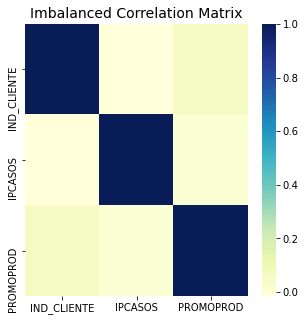

In [17]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(5,5))         

# Imbalanced DataFrame Correlation
corr = dset.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

In [18]:
dset.columns.values

array(['CANAL_REGISTRO', 'IND_CLIENTE', 'TIPOEMAIL', 'IPCASOS',
       'BONDAD_EMAIL', 'IP_Country', 'USU_TIPO', 'USU_TAMANIO',
       'USU_CIIU', 'PROMOPROD'], dtype=object)

## Separar los datos entre Train y Test:
<a name='traintest' />

In [19]:
X= dset.iloc[:,[0,2,3,4,5,6,7,8,9]]
Y = dset.iloc[:,[1]] 

X= StandardScaler().fit_transform(X)
 
# Separamos los datos en train y test

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

print('Disponemos de {} datos para entrenamiento y {} datos para prueba'.format(X_train.shape[0], X_test.shape[0]))

sm = SMOTE(sampling_strategy='minority', random_state=7)

oversampled_trainX, oversampled_trainY = sm.fit_sample(X_train,  y_train) #Cambio X por X_train, Y por y_train 20210518
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)


Disponemos de 81644 datos para entrenamiento y 20411 datos para prueba


# KNN
<a name='knn' />

### Busqueda de hiperparámetros:
<a name='knn_hiper' />

In [20]:
# model_knn = KNeighborsClassifier()
            
param_grid_knn = {"n_neighbors": range(1, 11), "weights": ["uniform", "distance"]}

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, cv=4)

grid_search_knn.fit(oversampled_trainX, oversampled_trainY)

means_knn = grid_search_knn.cv_results_["mean_test_score"]
stds_knn = grid_search_knn.cv_results_["std_test_score"]
params_knn = grid_search_knn.cv_results_['params']

# for mean, std, pms in zip(means_knn, stds_knn, params_knn):
#     print("Precisión media: {:.2f} +/- {:.2f} con parámetros {}".format(mean*100, std*100, pms))

print("Los mejores parámetros han sido: {}".format(grid_search_knn.best_params_))

Los mejores parámetros han sido: {'n_neighbors': 2, 'weights': 'distance'}


### Crear modelo Knn
<a name='knn_crear' />

In [21]:
bp_knn = grid_search_knn.best_params_
model_knn = KNeighborsClassifier(n_neighbors=bp_knn['n_neighbors'], weights=bp_knn['weights'])
model_knn.fit(oversampled_trainX, oversampled_trainY)

preds_knn = model_knn.predict(X_test)

In [ ]:
accuracy_score(y_test,preds_knn)

In [ ]:
recall_score(y_test,preds_knn)

In [ ]:
y_actual = y_test.iloc[:,0]

data = {'y_Actual':    y_actual,
        'y_Predicted': preds_knn
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
# sns.heatmap(confusion_matrix, annot=True)
# plt.show()


# Random Forest
<a name='randomforest' />

### Busqueda de hiperparámetros:
<a name='rf_hiper' />

In [22]:
# model_rf = RandomForestClassifier()

param_grid_rf = {"max_depth": range(6, 13), "n_estimators": [10, 50, 100, 200]}

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf, cv=4)
grid_search_rf.fit(oversampled_trainX, oversampled_trainY)

means_rf = grid_search_rf.cv_results_["mean_test_score"]
stds_rf = grid_search_rf.cv_results_["std_test_score"]
params_rf = grid_search_rf.cv_results_['params']

# for mean, std, pms in zip(means_rf, stds_rf, params_rf):
#     print("Precisión media: {:.2f} +/- {:.2f} con parámetros {}".format(mean*100, std*100, pms))

print("Los mejores parámetros han sido: {}".format(grid_search_rf.best_params_))

Los mejores parámetros han sido: {'max_depth': 12, 'n_estimators': 200}


### Crear el modelo Random Forest:
<a name='rf_crear' />

In [23]:
bp_rf = grid_search_rf.best_params_
model_rf = RandomForestClassifier(max_depth=bp_rf['max_depth'], n_estimators=bp_rf['n_estimators'])
model_rf.fit(oversampled_trainX, oversampled_trainY)

preds_rf = model_rf.predict(X_test)



In [ ]:
accuracy_score(y_test, preds_rf)

In [ ]:
y_actual = y_test.iloc[:,0]

data = {'y_Actual':    y_actual,
        'y_Predicted': preds_rf
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
# sns.heatmap(confusion_matrix, annot=True)
# plt.show()

# XGBoost
<a name='xgb' />

### Busqueda de hiperparámetros:
<a name='xgb_hiper' />

In [24]:
param_grid_xgb = {
                    'min_child_weight': [1, 5, 10],
                    'gamma': [0.5, 1, 1.5, 2, 5],
                    'subsample': [0.6, 0.8, 1.0],
                    'colsample_bytree': [0.6, 0.8, 1.0],
                    'max_depth': [3, 4, 5]
                    }

grid_search_xgb = GridSearchCV(xgb.XGBRegressor(), param_grid=param_grid_xgb, cv=4)
grid_search_xgb.fit(oversampled_trainX, oversampled_trainY)

means_xgb = grid_search_xgb.cv_results_["mean_test_score"]
stds_xgb = grid_search_xgb.cv_results_["std_test_score"]
params_xgb = grid_search_xgb.cv_results_['params']

# for mean, std, pms in zip(means_xgb, stds_xgb, params_xgb):
#     print("Precisión media: {:.2f} +/- {:.2f} con parámetros {}".format(mean*100, std*100, pms))

print("Los mejores parámetros han sido: {}".format(grid_search_xgb.best_params_))

Los mejores parámetros han sido: {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8}


### Crear el modelo XGBoost:
<a name='xgb_crear' />

In [25]:
bp_xgb = grid_search_xgb.best_params_
model_xgb = xgb.XGBRegressor(
                    min_child_weight= bp_xgb['min_child_weight'],
                    gamma= bp_xgb['gamma'],
                    subsample= bp_xgb['subsample'],
                    colsample_bytree=  bp_xgb['colsample_bytree'],
                    max_depth= bp_xgb['max_depth'])

model_xgb.fit(oversampled_trainX, oversampled_trainY)

preds_xgb = model_xgb.predict(X_test)

# accuracy_xgb = np.true_divide(np.sum(preds_xgb == y_test), preds_xgb.shape[0])*100
# xgb_matrix = confusion_matrix(y_test, preds_xgb)

# print(accuracy_xgb)
# print(xgb_matrix)

In [ ]:
accuracy_score(y_test, preds_xgb.round())

In [ ]:
y_actual = y_test.iloc[:,0]

data = {'y_Actual':    y_actual,
        'y_Predicted': preds_xgb.round()
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

## Análisis de resultados:
<a name='resultados' />

In [26]:
mae_knn = mean_absolute_error(y_test, preds_knn)
mae_rf = mean_absolute_error(y_test, preds_rf)
mae_xgb = mean_absolute_error(y_test, preds_xgb)
                              
mse_knn = mean_squared_error(y_test, preds_knn)  
mse_rf = mean_squared_error(y_test, preds_rf)
mse_xgb = mean_squared_error(y_test, preds_xgb)

recall_knn = recall_score(y_test,preds_knn)
recall_rf = recall_score(y_test,preds_rf)
recall_xgb = recall_score(y_test,preds_xgb.round())

compare_models = pd.DataFrame(
    {  'Model' : ['Knn', 'RandomForest','XGB'],
       'Score' : [model_knn.score(X_test,y_test), model_rf.score(X_test,y_test),model_xgb.score(X_test,y_test)],
        'MAE'  : [mae_knn,mae_rf,mae_xgb],
        'MSE'  : [mse_knn,mse_rf,mse_xgb],
        'Recall': [recall_knn,recall_rf,recall_xgb]
    })
  
print(compare_models)

          Model     Score       MAE       MSE    Recall
0           Knn  0.960218  0.039782  0.039782  0.244361
1  RandomForest  0.947185  0.052815  0.052815  0.680451
2           XGB -0.346578  0.063544  0.017320  0.327068


In [51]:
for i in range(X_test.shape[1]):
    X = X_test[:, i].reshape(-1, 1)
    scores = cross_val_score(model_rf, X, preds_rf, cv=3)
    print(f'{i}        {scores.mean():g}')

0        0.942482
1        0.942482
2        0.942139
3        0.942482
4        0.942335
5        0.942482
6        0.942482
7        0.941992
8        0.95282


# Escenario 2 <a name='escenario2' />

## TIPOUSUARIO = 'PF'

In [41]:
df2 = data_consum[['IDUSUARIO', 'IDGRUPOPROD']]
df2['IDGRUPOPROD'] = np.where(df2['IDGRUPOPROD'] == 144917, 'promo'
        , np.where(df2['IDGRUPOPROD'] == 144920, 'promo'
                  , 'pago'))

df_filter2  = pd.DataFrame(df2.groupby(by=['IDUSUARIO','IDGRUPOPROD'],as_index=False)['IDUSUARIO'].size())
df2 = df_filter2[df_filter2['IDGRUPOPROD'] == 'promo']
df2 = df2.rename(columns={'size':'PROMOPROD'})

df_merge2 = pd.merge(data_user,df2, on='IDUSUARIO')

df_merge2 = df_merge2[df_merge2['TIPOUSUARIO'] == 'PF'] #Cambio esencial en este escenario

dset2 = df_merge2[['CANAL_REGISTRO','IND_CLIENTE','TIPOEMAIL','IPCASOS'
                , 'BONDAD_EMAIL','IP_Country', 'PROMOPROD']]

dset2['CANAL_REGISTRO'] = dset2['CANAL_REGISTRO'].astype('category')

# dset2['BONDAD_EMAIL'] = dset2['BONDAD_EMAIL'].astype('category')

dset2['IP_Country'] = dset2['IP_Country'].astype('category')
dset2['IP_Country'] = dset2['IP_Country'].cat.codes
dset2['IP_Country'] = dset2['IP_Country'].astype('category')

dset2['TIPOEMAIL'] = dset2['TIPOEMAIL'].astype('category')
dset2['TIPOEMAIL'] = dset2['TIPOEMAIL'].cat.codes
dset2['TIPOEMAIL'] = dset2['TIPOEMAIL'].astype('category')


dset2 = dset2.apply(lambda x: x.fillna(x.value_counts().index[0]))

dset2.info()




<class 'pandas.core.frame.DataFrame'>
Int64Index: 266142 entries, 0 to 368196
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   CANAL_REGISTRO  266142 non-null  category
 1   IND_CLIENTE     266142 non-null  int64   
 2   TIPOEMAIL       266142 non-null  category
 3   IPCASOS         266142 non-null  int64   
 4   BONDAD_EMAIL    266142 non-null  int64   
 5   IP_Country      266142 non-null  category
 6   PROMOPROD       266142 non-null  int64   
dtypes: category(3), int64(4)
memory usage: 10.9 MB


In [47]:
X2 = dset2.iloc[:,[0,2,3,4,5,6]]
Y2 = dset2.iloc[:,[1]] 

X2 = StandardScaler().fit_transform(X2)
 
# Separamos los datos en train y test

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.2)

# print('Disponemos de {} datos para entrenamiento y {} datos para prueba'.format(X_train.shape[0], X_test.shape[0]))

sm2 = SMOTE(sampling_strategy='minority', random_state=7)

oversampled_trainX2, oversampled_trainY2 = sm2.fit_sample(X_train2,  y_train2)
oversampled_train2 = pd.concat([pd.DataFrame(oversampled_trainY2), pd.DataFrame(oversampled_trainX2)], axis=1)

param_grid_knn2 = {"n_neighbors": range(1, 11), "weights": ["uniform", "distance"]}

grid_search_knn2 = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn2, cv=4)

grid_search_knn2.fit(oversampled_trainX2, oversampled_trainY2)

bp_knn2 = grid_search_knn2.best_params_
model_knn2 = KNeighborsClassifier(n_neighbors=bp_knn2['n_neighbors'], weights=bp_knn2['weights'])
model_knn2.fit(oversampled_trainX2, oversampled_trainY2)

preds_knn2 = model_knn2.predict(X_test2)

param_grid_rf2 = {"max_depth": range(6, 13), "n_estimators": [10, 50, 100, 200]}

grid_search_rf2 = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf2, cv=4)
grid_search_rf2.fit(oversampled_trainX2, oversampled_trainY2)

bp_rf2 = grid_search_rf2.best_params_
model_rf2 = RandomForestClassifier(max_depth=bp_rf2['max_depth'], n_estimators=bp_rf2['n_estimators'])
model_rf2.fit(oversampled_trainX2, oversampled_trainY2)

preds_rf2 = model_rf2.predict(X_test2)

param_grid_xgb2 = {
                    'min_child_weight': [1, 5, 10],
                    'gamma': [0.5, 1, 1.5, 2, 5],
                    'subsample': [0.6, 0.8, 1.0],
                    'colsample_bytree': [0.6, 0.8, 1.0],
                    'max_depth': [3, 4, 5]
                    }

grid_search_xgb2 = GridSearchCV(xgb.XGBRegressor(), param_grid=param_grid_xgb2, cv=4)
grid_search_xgb2.fit(oversampled_trainX2, oversampled_trainY2)

bp_xgb2 = grid_search_xgb2.best_params_
model_xgb2 = xgb.XGBRegressor(
                    min_child_weight= bp_xgb2['min_child_weight'],
                    gamma= bp_xgb2['gamma'],
                    subsample= bp_xgb2['subsample'],
                    colsample_bytree=  bp_xgb2['colsample_bytree'],
                    max_depth= bp_xgb2['max_depth'])

model_xgb2.fit(oversampled_trainX2, oversampled_trainY2)

preds_xgb2 = model_xgb2.predict(X_test2)

## Resultados escenario 2 <a name='resultados2' />

In [62]:
mae_knn2 = mean_absolute_error(y_test2, preds_knn2)
mae_rf2 = mean_absolute_error(y_test2, preds_rf2)
mae_xgb2 = mean_absolute_error(y_test2, preds_xgb2)
                              
mse_knn2 = mean_squared_error(y_test2, preds_knn2)  
mse_rf2 = mean_squared_error(y_test2, preds_rf2)
mse_xgb2 = mean_squared_error(y_test2, preds_xgb2)

recall_knn2 = recall_score(y_test2,preds_knn2)
recall_rf2 = recall_score(y_test2,preds_rf2)
recall_xgb2 = recall_score(y_test2,preds_xgb2.round())
# recall_xgb2 = 0


compare_models2 = pd.DataFrame(
    {  'Model' : ['Knn', 'RandomForest','XGB'],
       'Score' : [model_knn2.score(X_test2,y_test2), model_rf2.score(X_test2,y_test2),model_xgb2.score(X_test2,y_test2)],
        'MAE'  : [mae_knn2,mae_rf2,mae_xgb2],
        'MSE'  : [mse_knn2,mse_rf2,mse_xgb2],
        'Recall': [recall_knn2,recall_rf2,recall_xgb2]
    })
  
print(compare_models2)

          Model      Score       MAE       MSE    Recall
0           Knn   0.956358  0.043642  0.043642  0.223256
1  RandomForest   0.904939  0.095061  0.095061  0.655814
2           XGB -10.197724  0.129181  0.045047  0.460465


In [50]:
for i in range(X_test2.shape[1]):
    X = X_test2[:, i].reshape(-1, 1)
    scores = cross_val_score(model_knn2, X, preds_knn2, cv=3)
    print(f'{i}        {scores.mean():g}')

0        0.958594
1        0.958594
2        0.932612
3        0.744387
4        0.9585
5        0.883447


# Escenario 3 <a name='escenario3' />

## Sin separar por tipo de usuario

In [52]:
df3 = data_consum[['IDUSUARIO', 'IDGRUPOPROD']]
df3['IDGRUPOPROD'] = np.where(df3['IDGRUPOPROD'] == 144917, 'promo'
        , np.where(df3['IDGRUPOPROD'] == 144920, 'promo'
                  , 'pago'))

df_filter3  = pd.DataFrame(df3.groupby(by=['IDUSUARIO','IDGRUPOPROD'],as_index=False)['IDUSUARIO'].size())
df3 = df_filter2[df_filter3['IDGRUPOPROD'] == 'promo']
df3 = df3.rename(columns={'size':'PROMOPROD'})

df_merge3 = pd.merge(data_user,df3, on='IDUSUARIO')

# df_merge3 = df_merge3[df_merge3['TIPOUSUARIO'] == 'PF'] #Cambio esencial en este escenario

dset3 = df_merge3[['TIPOUSUARIO','CANAL_REGISTRO','IND_CLIENTE','TIPOEMAIL','IPCASOS'
                , 'BONDAD_EMAIL','IP_Country', 'PROMOPROD']]

dset3['CANAL_REGISTRO'] = dset3['CANAL_REGISTRO'].astype('category')

# dset2['BONDAD_EMAIL'] = dset2['BONDAD_EMAIL'].astype('category')
dset3['TIPOUSUARIO'] = dset3['TIPOUSUARIO'].astype('category')
dset3['TIPOUSUARIO'] = dset3['TIPOUSUARIO'].cat.codes
dset3['TIPOUSUARIO'] = dset3['TIPOUSUARIO'].astype('category')

dset3['IP_Country'] = dset3['IP_Country'].astype('category')
dset3['IP_Country'] = dset3['IP_Country'].cat.codes
dset3['IP_Country'] = dset3['IP_Country'].astype('category')

dset3['TIPOEMAIL'] = dset3['TIPOEMAIL'].astype('category')
dset3['TIPOEMAIL'] = dset3['TIPOEMAIL'].cat.codes
dset3['TIPOEMAIL'] = dset3['TIPOEMAIL'].astype('category')


dset3 = dset3.apply(lambda x: x.fillna(x.value_counts().index[0]))

dset3.info()




<class 'pandas.core.frame.DataFrame'>
Int64Index: 368197 entries, 0 to 368196
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   TIPOUSUARIO     368197 non-null  category
 1   CANAL_REGISTRO  368197 non-null  category
 2   IND_CLIENTE     368197 non-null  int64   
 3   TIPOEMAIL       368197 non-null  category
 4   IPCASOS         368197 non-null  int64   
 5   BONDAD_EMAIL    368197 non-null  int64   
 6   IP_Country      368197 non-null  category
 7   PROMOPROD       368197 non-null  int64   
dtypes: category(4), int64(4)
memory usage: 15.5 MB


In [53]:
X3 = dset3.iloc[:,[0,1,3,4,5,6,7]]
Y3 = dset3.iloc[:,[2]] 

X3 = StandardScaler().fit_transform(X3)
 
# Separamos los datos en train y test

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, Y3, test_size=0.2)

# print('Disponemos de {} datos para entrenamiento y {} datos para prueba'.format(X_train.shape[0], X_test.shape[0]))

sm3 = SMOTE(sampling_strategy='minority', random_state=7)

oversampled_trainX3, oversampled_trainY3 = sm3.fit_sample(X_train3,  y_train3)
oversampled_train3 = pd.concat([pd.DataFrame(oversampled_trainY3), pd.DataFrame(oversampled_trainX3)], axis=1)

param_grid_knn3 = {"n_neighbors": range(1, 11), "weights": ["uniform", "distance"]}

grid_search_knn3 = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn3, cv=4)

grid_search_knn3.fit(oversampled_trainX3, oversampled_trainY3)

bp_knn3 = grid_search_knn3.best_params_
model_knn3 = KNeighborsClassifier(n_neighbors=bp_knn3['n_neighbors'], weights=bp_knn3['weights'])
model_knn3.fit(oversampled_trainX3, oversampled_trainY3)

preds_knn3 = model_knn3.predict(X_test3)

param_grid_rf3 = {"max_depth": range(6, 13), "n_estimators": [10, 50, 100, 200]}

grid_search_rf3 = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf3, cv=4)
grid_search_rf3.fit(oversampled_trainX3, oversampled_trainY3)

bp_rf3 = grid_search_rf3.best_params_
model_rf3 = RandomForestClassifier(max_depth=bp_rf3['max_depth'], n_estimators=bp_rf3['n_estimators'])
model_rf3.fit(oversampled_trainX3, oversampled_trainY3)

preds_rf3 = model_rf3.predict(X_test3)

param_grid_xgb3 = {
                    'min_child_weight': [1, 5, 10],
                    'gamma': [0.5, 1, 1.5, 2, 5],
                    'subsample': [0.6, 0.8, 1.0],
                    'colsample_bytree': [0.6, 0.8, 1.0],
                    'max_depth': [3, 4, 5]
                    }

grid_search_xgb3 = GridSearchCV(xgb.XGBRegressor(), param_grid=param_grid_xgb3, cv=4)
grid_search_xgb3.fit(oversampled_trainX3, oversampled_trainY3)

bp_xgb3 = grid_search_xgb3.best_params_
model_xgb3 = xgb.XGBRegressor(
                    min_child_weight= bp_xgb3['min_child_weight'],
                    gamma= bp_xgb3['gamma'],
                    subsample= bp_xgb3['subsample'],
                    colsample_bytree=  bp_xgb3['colsample_bytree'],
                    max_depth= bp_xgb3['max_depth'])

model_xgb3.fit(oversampled_trainX3, oversampled_trainY3)

preds_xgb3 = model_xgb3.predict(X_test3)

## Resultados escenario 3 <a name='resultados3' />

In [68]:
mae_knn3 = mean_absolute_error(y_test3, preds_knn3)
mae_rf3 = mean_absolute_error(y_test3, preds_rf3)
mae_xgb3 = mean_absolute_error(y_test3, preds_xgb3)
                              
mse_knn3 = mean_squared_error(y_test3, preds_knn3)  
mse_rf3 = mean_squared_error(y_test3, preds_rf3)
mse_xgb3 = mean_squared_error(y_test3, preds_xgb3)

recall_knn3 = recall_score(y_test3,preds_knn3)
recall_rf3 = recall_score(y_test3,preds_rf3)
# recall_xgb3 = recall_score(y_test3,preds_xgb3.round())
recall_xgb3 = 0


compare_models3 = pd.DataFrame(
    {  'Model' : ['Knn', 'RandomForest','XGB'],
       'Score' : [model_knn3.score(X_test3,y_test3), model_rf3.score(X_test3,y_test3),model_xgb3.score(X_test3,y_test3)],
        'MAE'  : [mae_knn3,mae_rf3,mae_xgb3],
        'MSE'  : [mse_knn3,mse_rf3,mse_xgb3],
        'Recall': [recall_knn3,recall_rf3,recall_xgb3]
    })
  
print(compare_models3)

          Model     Score       MAE       MSE    Recall
0           Knn  0.971727  0.028273  0.028273  0.309434
1  RandomForest  0.904848  0.095152  0.095152  0.766038
2           XGB -4.992069  0.125035  0.042816  0.000000
